# Network traffic anomaly detection with machine learning

_**Setting**_: The IT department of a tech company is concerned about novel, recent cyber-attacks
attempting to compromise different assets in its network. To enhance the level of protection
against these attacks, they have asked you to help design a machine learning (ML) system to
detect anomalous traffic in the network.

_**Questions**_: 

#### What questions or details would you ask to the IT department to help you design such anomaly detection system?

- Is the network monitored? Is network traffic captured?
- Do you have network traffic captured related to the mentioned devices?
- What is the format of the captured network traffic (PCAP, Netflow...)?
- If you have captured network traffic, are the anomalies labeled?
- Do you want the model to monitor specific assets or the hole network?
- Do you want to classify anomalies or just detect them?

#### How would you collect and process the data necessary to train the ML model? What would be their structure, type, size, etc.?

By having a probe on the network capturing network traffic in a NetFlow-based format we can store it in a database (SQL, MySQL, ..), This data can be analyzed and preprocessed, the following steps should be followed:

1. Choose a time interval where there are known attacks.
2. Split the dataset in 70% train and 30% test.
3. Perform an EDA over the train partition mainly checking missing data, the distribution of continuous features and frecuency distributions for categorical features.
4. Drop missing values from train partition. For this kind of data I discard imputation, the imputed data in this case could be misleading for the models.
5. In the train partition, Standarize or normalize continuous features and perform one-hot encoding to categorical features.
6. Perform feature selection in the train partition.
7. Perform data augmentation to balance the classes.
8. Repeat 4, 5 and 6 over the test partition using the fitted stimators.

This is a preprocessing meant for classic models, i.e. neural networks can work with a higger number of variables without being impacted by the course of dimensionality.

#### Based on your previous answer, what ML algorithms would you consider for your system? How would you select the best model amongst the ones considered, and how would you evaluate the model’s performance?

If we have labeled data we can train supervised binary classificators such as SVMs, random forests, gradient boosting machines, neural network models...

The choose of the metrics for evaluating model performance depends on the balance between the two classes. If they are balanced ROC AUC is a good choice but this metric can be misleading if they are severely imbalanced, in this case precision recall AUC is more interesting.

The methodology for model selection is to train the models with the train partion and evaluate them using the test partition, the best model will be the one with the best metric. Other interesting technique is Kfold validation but this is a very time consumming approach.

My first approach for this model selection is to train a few classic classifiers with a few hyperparameter configurations, after that train a neural network based model, then choose the best model to perform hyperparameter tunning.

#### The IT department warned the team that the company introduces or discontinues the use of applications (that produce network traffic) with a moderate frequency. This decision can affect the performance of the system proposed. Given this extra information, what changes would you make to the proposed system to work properly in production? What factors do you need to consider for ensuring a good performance in the proposed ML system?


This scenario indicates us that the model is going to be exposed to new unseen data in the future. There are several acctions that can be taken:

- The deployed model should be monitored to detect deviations on its performance.
- The dataset must be updated periodicaly to introduce network traffic from new applications or remove network traffic from discontinued applications, the implementation of a feedback loop with feedback data from the IT team could be interesting.
- Updating the dataset makes it necessary to retrain and redeploy the model.

#### Given the above preparation, please proceed with implementing this system, with an ML model of your choice that detects anomalies within the following dataset: https://www.kaggle.com/datasets/anushonkar/network-anamoly-detection?resource=download

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb

from imblearn.over_sampling import ADASYN
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectPercentile, SelectKBest, VarianceThreshold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.svm import SVC
from scipy import stats

2023-09-10 01:09:56.517919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 01:09:56.616317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 01:09:56.618005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 01:09:57.640489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [3]:
df = pd.read_csv('../data/Train.txt', names=columns, header=None)
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

Let's check out if the numeric features follow a normal distribution

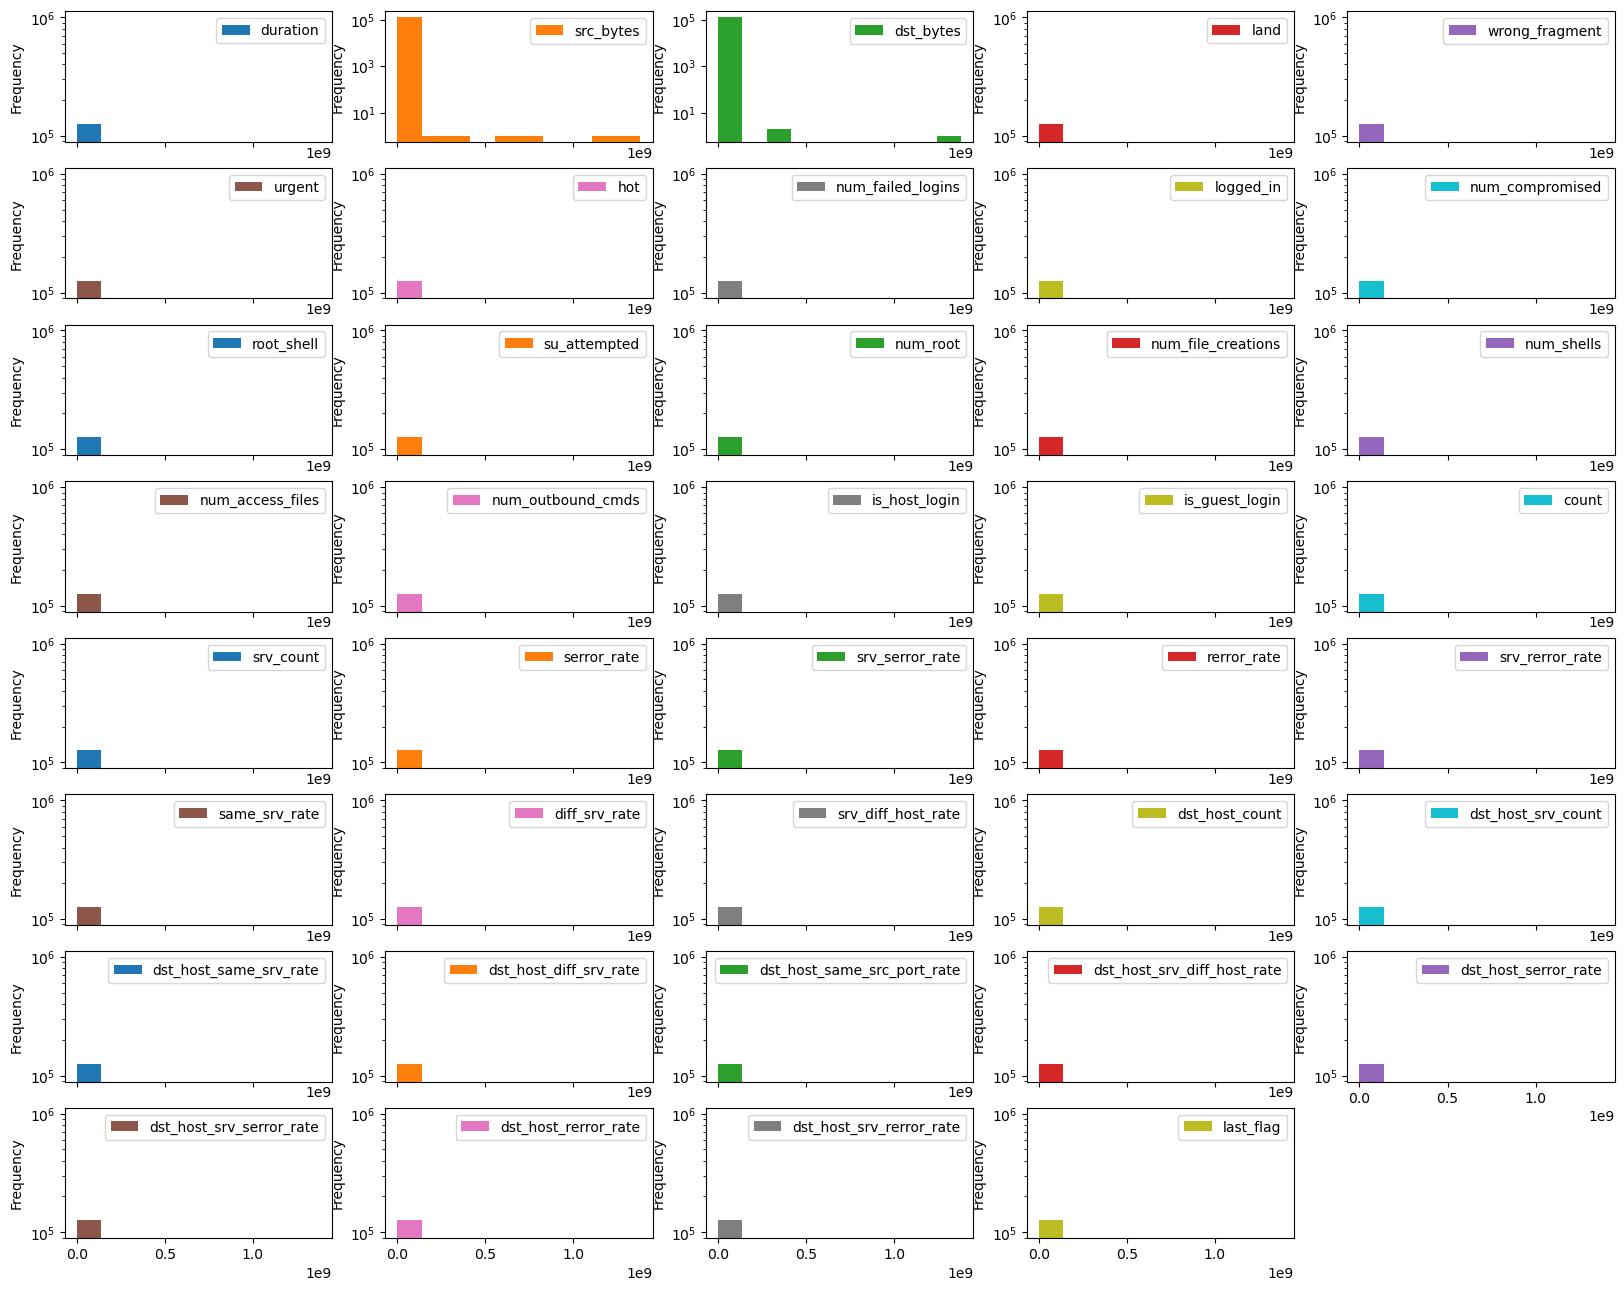

In [5]:
df.drop(columns=["attack"]). \
    plot.hist(subplots = True, 
              layout=(10,5),
              figsize=(20,20),
              bins=10,
              log=True
    )

plt.show()

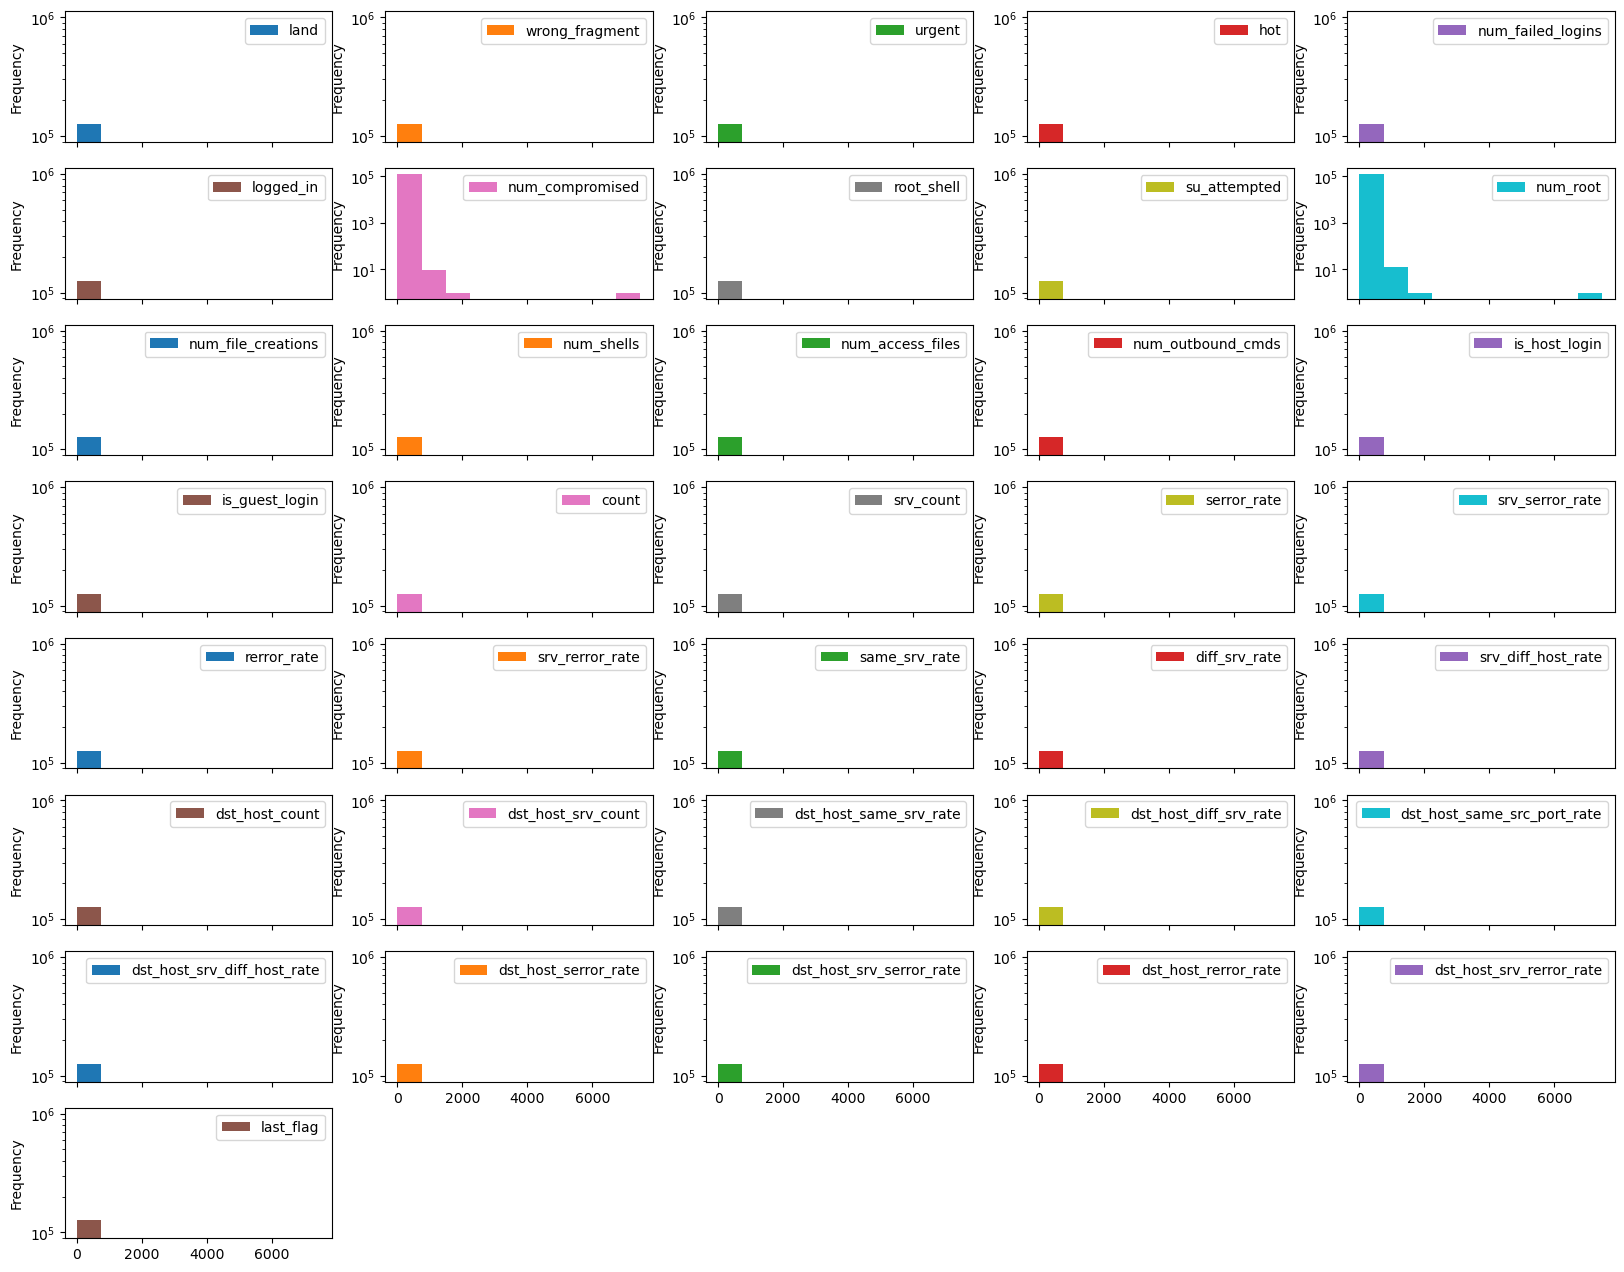

In [6]:
df.drop(columns=["attack","src_bytes", "dst_bytes", "duration"]). \
    plot.hist(subplots = True, 
              layout=(10,5),
              figsize=(20,20),
              bins=10,
              log=True
    )

plt.show()

The previous plots were not conclusive, we are going to check the distribution using a statistical test.

In [7]:
normally_distributed = []
for column in df[df.select_dtypes(include='number').columns]:
    anderson_stat, critical_values, significance_levels = stats.anderson(df[column].values, dist='norm')
    if np.all((anderson_stat < critical_values) == True):
        normaly_distributed.append(normaly_distributed)

print(f'There are {len(normally_distributed)} normally distributed columns')

/opt/conda/lib/python3.11/site-packages/scipy/stats/_morestats.py:2121: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s


There are 0 normally distributed columns


None of the numeric features follow a normal distribution, normalization is necessary in all of them.

Now we are going to check categorical features.

In [8]:
df.describe(include=["object"])

,protocol_type,service,flag,attack
count,125973,125973,125973,125973
unique,3,70,11,23
top,tcp,http,SF,normal
freq,102689,40338,74945,67343


<Axes: xlabel='protocol_type'>

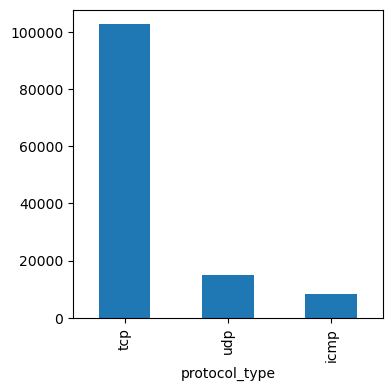

In [9]:
df.protocol_type.value_counts().plot(kind='bar', figsize=(4,4),)

<Axes: xlabel='service'>

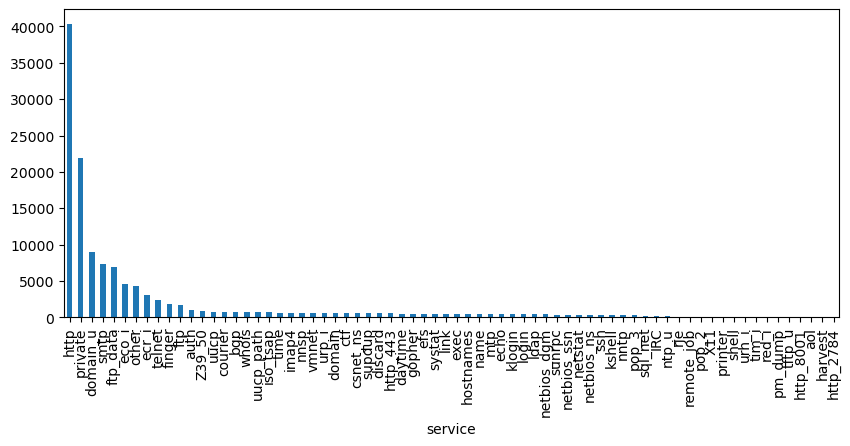

In [10]:
df.service.value_counts().plot(kind='bar', figsize=(10,4),)

<Axes: xlabel='flag'>

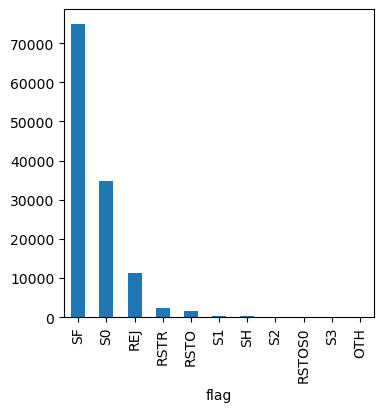

In [11]:
df.flag.value_counts().plot(kind='bar', figsize=(4,4),)

<Axes: xlabel='attack'>

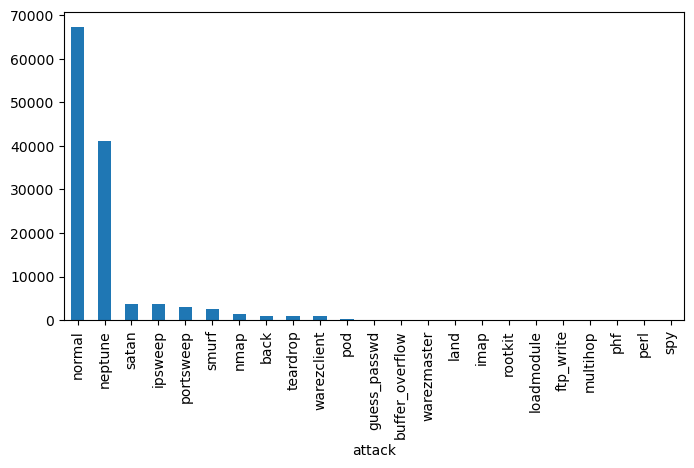

In [12]:
df.attack.value_counts().plot(kind='bar', figsize=(8,4),)

The system is meant to detect anomalies, anomaly classification can be assumed as future work. Normal trafic is going to be relabeled as 0 and attacks as 1.

In [13]:
df.attack = df.attack.apply(lambda x: 0 if x == "normal" else 1)

<Axes: xlabel='attack'>

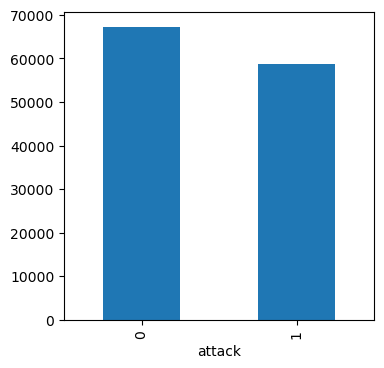

In [14]:
df.attack.value_counts().plot(kind='bar', figsize=(4,4),)

In [15]:
X_train = df.drop(columns=["attack"])
Y_train = df.attack

df_test = pd.read_csv('../data/Test.txt', names=columns, header=None)
X_test = df_test.drop(columns=["attack"])
Y_test = df_test.attack.apply(lambda x: 0 if x == "normal" else 1)

The definition of the data preprocessing is going to be implemented in a sklearn pipeline following the steps stated on the previous questions.

In [16]:
preprocessing_pipelines = {}
preprocessing_pipeline = Pipeline([
                            (
                                "feature-preprocessing", ColumnTransformer([
                                    (
                                         "continuous-preprocessing", 
                                         Normalizer(),
                                         X_train.select_dtypes(include='number').columns
                                    ),
                                    (
                                        "categorical-preprocessing",
                                        OneHotEncoder(),
                                        X_train.select_dtypes(include='object').columns
                                    )
                                ])
                            ), 
                            (
                                "feature-selection", 
                                Pipeline([
                                    (
                                        "remove-constant-features", VarianceThreshold()       
                                    ),
                                    (
                                        "percentile-selector", SelectPercentile(percentile=10)
                                    )
                                ])
                            )
                        ])

preprocessing_pipelines[1] = preprocessing_pipeline
preprocessing_pipeline

Pipeline(steps=[('feature-preprocessing',
                 ColumnTransformer(transformers=[('continuous-preprocessing',
                                                  Normalizer(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound...
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'last_flag'],
      dtype='object')),
                                                 ('categorical-preprocessing',
                                                  OneHotEncoder(),
                                                  Index(['protocol_type', 'service', 'flag'], dtype='object'))])),
                ('feature-selection',
                 Pipeline(steps=[('remove-constant-features',
                                  VarianceThreshold()),
                                 ('percentile-selector',
                                  SelectPercentile())]))])

In [17]:
random_state = 1
tf.random.set_seed(random_state)
tf.keras.utils.set_random_seed(random_state)


def preprocess(X_train, Y_train, X_test, pipeline):
    oversampler = ADASYN(random_state=random_state) # this is not integrated with the sklearn api conventions

    X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train, Y_train)
    X_train_preprocessed, Y_train_preprocessed = oversampler.fit_resample(X_train_preprocessed, Y_train)
    X_test_preprocessed = preprocessing_pipeline.transform(X_test)
    
    return X_train_preprocessed, Y_train_preprocessed, X_test_preprocessed

In [18]:
X_train_preprocessed, Y_train_preprocessed, X_test_preprocessed = preprocess(X_train, Y_train, X_test, preprocessing_pipeline)

In [19]:
np.shape(X_train_preprocessed)

(134645, 13)

In [20]:
np.shape(X_test_preprocessed)

(22544, 13)

In this case we don´t have a MLFlow server to track the experiments, we are going to simply use a dataframe to correctly visualize metrics (in this case we are going to use ROC AUC and precision recall AUC evaluate models).

In [21]:
def train_classifiers(models):
    results = {}
    for idx, i in models.items():
        print(f"___{idx}___")
        classifier = i
        
        classifier.fit(X_train_preprocessed, Y_train_preprocessed)
        y_pred = classifier.predict(X_test_preprocessed)
        
        roc_auc = roc_auc_score(Y_test, y_pred)

        precision, recall, _ = precision_recall_curve(Y_test, y_pred)
        pr_auc = auc(recall, precision)
        
        print(f"ROC AUC score {roc_auc}")
        print(f"Precision-Recall AUC score {pr_auc}\n")
        
        results[idx] = {
                "roc_auc_score": roc_auc,
                "precision_recall_auc_score": pr_auc,
                "model": classifier,
                "preprocessing": 1,
        }

    return results

The following models are going to be used:

- Random forest
- SVC
- AdaBoost
- XGBoost
- LightGBM

In [22]:
models = {
    "random-forest estimators=100": RandomForestClassifier(100, n_jobs=-1, random_state=random_state),
    "random-forest estimators=250": RandomForestClassifier(250, n_jobs=-1, random_state=random_state),
    "SVC C=1.0": SVC(C=1.0, random_state=random_state),
    "SVC C=0.85": SVC(C=0.85, random_state=random_state),
    "AdaBoost estimators=10": AdaBoostClassifier(n_estimators=10, random_state=random_state),
    "AdaBoost estimators=50": AdaBoostClassifier(n_estimators=50, random_state=random_state),
    "XGBoost 1": xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=random_state),
    "XGBoost 2": xgb.XGBClassifier(n_estimators=150, n_jobs=-1, random_state=random_state),
    "LightGBM 1": lgb.LGBMClassifier(num_leaves=31, n_jobs=-1, random_state=random_state),
    "LightGBM 2": lgb.LGBMClassifier(num_leaves=51, n_jobs=-1, random_state=random_state),
}

In [23]:
results = train_classifiers(models)

___random-forest estimators=100___
ROC AUC score 0.8224963824993493
Precision-Recall AUC score 0.9119375883728599

___random-forest estimators=250___
ROC AUC score 0.8212885589195159
Precision-Recall AUC score 0.9113508079045469

___SVC C=1.0___
ROC AUC score 0.8379547838477611
Precision-Recall AUC score 0.9092948884930169

___SVC C=0.85___
ROC AUC score 0.8379283477491318
Precision-Recall AUC score 0.9092972321379508

___AdaBoost estimators=10___
ROC AUC score 0.7665199838329355
Precision-Recall AUC score 0.8650787574437391

___AdaBoost estimators=50___
ROC AUC score 0.7732958419784272
Precision-Recall AUC score 0.8738892887741466

___XGBoost 1___


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


ROC AUC score 0.8257092651997917
Precision-Recall AUC score 0.9124463857229919

___XGBoost 2___


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


ROC AUC score 0.8233687737541225
Precision-Recall AUC score 0.9114607847323686

___LightGBM 1___
[LightGBM] [Info] Number of positive: 67302, number of negative: 67343
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 134645, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499848 -> initscore=-0.000609
[LightGBM] [Info] Start training from score -0.000609
ROC AUC score 0.8363528260823357
Precision-Recall AUC score 0.9172623389294091

___LightGBM 2___
[LightGBM] [Info] Number of positive: 67302, number of negative: 67343
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if m

The next models are going to be a pair of classifiers based on neural networks.

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(13, input_shape=(13,)),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_1'] = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 1,
}

Epoch 1/20
4208/4208 [==============================] - 7s 1ms/step - loss: 0.6960 - auc: 0.5235 - auc_1: 0.4870
Epoch 2/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.5595 - auc: 0.8921 - auc_1: 0.9151
Epoch 3/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.4596 - auc: 0.9116 - auc_1: 0.9303
Epoch 4/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3999 - auc: 0.9136 - auc_1: 0.9327
Epoch 5/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3666 - auc: 0.9139 - auc_1: 0.9333
Epoch 6/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3480 - auc: 0.9136 - auc_1: 0.9334
Epoch 7/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3368 - auc: 0.9134 - auc_1: 0.9334
Epoch 8/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3296 - auc: 0.9139 - auc_1: 0.9336
Epoch 9/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3245 - auc: 0.9152

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(13, input_shape=(13,)),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_2'] = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 1,
}

Epoch 1/20
4208/4208 [==============================] - 6s 1ms/step - loss: 0.5145 - auc_2: 0.8449 - auc_3: 0.8878
Epoch 2/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3757 - auc_2: 0.9166 - auc_3: 0.9336
Epoch 3/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3302 - auc_2: 0.9235 - auc_3: 0.9381
Epoch 4/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3162 - auc_2: 0.9267 - auc_3: 0.9404
Epoch 5/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3100 - auc_2: 0.9289 - auc_3: 0.9420
Epoch 6/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3061 - auc_2: 0.9306 - auc_3: 0.9431
Epoch 7/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3028 - auc_2: 0.9323 - auc_3: 0.9444
Epoch 8/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.3000 - auc_2: 0.9339 - auc_3: 0.9456
Epoch 9/20
4208/4208 [==============================] - 5s 1ms/step - loss: 0.29

In [26]:
results_df = pd.DataFrame().from_dict(results, orient='index')
results_df

,roc_auc_score,precision_recall_auc_score,model,preprocessing,loss
random-forest estimators=100,0.822496,0.911938,"(DecisionTreeClassifier(max_features='sqrt', r...",1,NaN
random-forest estimators=250,0.821289,0.911351,"(DecisionTreeClassifier(max_features='sqrt', r...",1,NaN
SVC C=1.0,0.837955,0.909295,SVC(random_state=1),1,NaN
SVC C=0.85,0.837928,0.909297,"SVC(C=0.85, random_state=1)",1,NaN
AdaBoost estimators=10,0.766520,0.865079,"(DecisionTreeClassifier(max_depth=1, random_st...",1,NaN
AdaBoost estimators=50,0.773296,0.873889,"(DecisionTreeClassifier(max_depth=1, random_st...",1,NaN
XGBoost 1,0.825709,0.912446,"XGBClassifier(base_score=None, booster=None, c...",1,NaN
XGBoost 2,0.823369,0.911461,"XGBClassifier(base_score=None, booster=None, c...",1,NaN
LightGBM 1,0.836353,0.917262,"LGBMClassifier(n_jobs=-1, random_state=1)",1,NaN
LightGBM 2,0.832899,0.915525,"LGBMClassifier(n_jobs=-1, num_leaves=51, rando...",1,NaN


<Axes: >

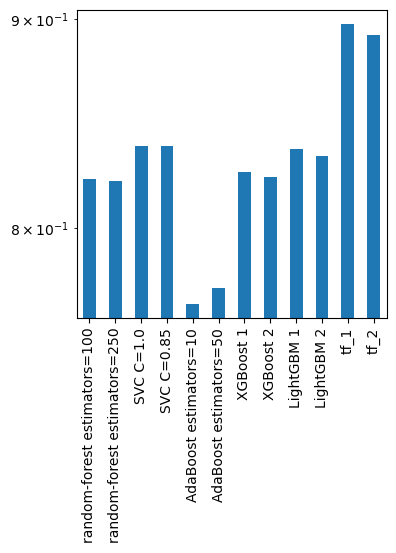

In [27]:
results_df.roc_auc_score.plot(kind='bar', figsize=(4,4), logy=True)

<Axes: >

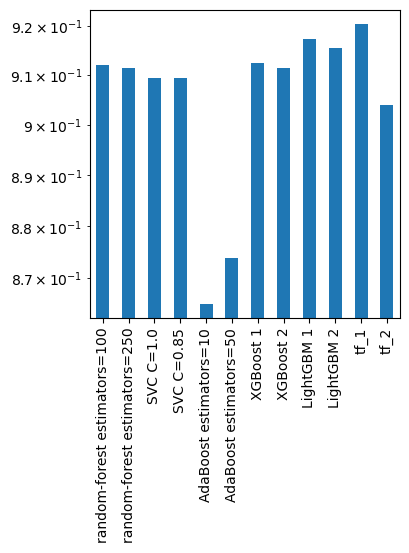

In [28]:
results_df.precision_recall_auc_score.plot(kind='bar', figsize=(4,4), logy=True)

The best-performing model is tf_1, we are going to test different number of features and architectures to increate the performance. 

In [29]:
preprocessing_pipeline = Pipeline([
                            (
                                "feature-preprocessing", ColumnTransformer([
                                    (
                                         "continuous-preprocessing", 
                                         Normalizer(),
                                         X_train.select_dtypes(include='number').columns
                                    ),
                                    (
                                        "categorical-preprocessing",
                                        OneHotEncoder(),
                                        X_train.select_dtypes(include='object').columns
                                    )
                                ])
                            ), 
                            (
                                "feature-selection", 
                                Pipeline([
                                    (
                                        "remove-constant-features", VarianceThreshold()       
                                    ),
                                    (
                                        "percentile-selector", SelectPercentile(percentile=20) 
                                    )
                                ])
                            )
                        ])

preprocessing_pipelines[2] = preprocessing_pipeline
preprocessing_pipeline

Pipeline(steps=[('feature-preprocessing',
                 ColumnTransformer(transformers=[('continuous-preprocessing',
                                                  Normalizer(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound...
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'last_flag'],
      dtype='object')),
                                                 ('categorical-preprocessing',
                                                  OneHotEncoder(),
                                                  Index(['protocol_type', 'service', 'flag'], dtype='object'))])),
                ('feature-selection',
                 Pipeline(steps=[('remove-constant-features',
                                  VarianceThreshold()),
                                 ('percentile-selector',
                                  SelectPercentile(percentile=20))]))])

In [30]:
X_train_preprocessed, Y_train_preprocessed, X_test_preprocessed = preprocess(X_train, Y_train, X_test, preprocessing_pipeline)
np.shape(X_train_preprocessed)

(134719, 25)

The number of features has been increased from 13 to 25.

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(13, input_shape=(25,)),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_3'] = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 2,
}

Epoch 1/20
4210/4210 [==============================] - 6s 1ms/step - loss: 0.5525 - auc_4: 0.8891 - auc_5: 0.8908
Epoch 2/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.4616 - auc_4: 0.9239 - auc_5: 0.9313
Epoch 3/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.3924 - auc_4: 0.9347 - auc_5: 0.9415
Epoch 4/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.3439 - auc_4: 0.9407 - auc_5: 0.9475
Epoch 5/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.3117 - auc_4: 0.9445 - auc_5: 0.9511
Epoch 6/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2897 - auc_4: 0.9477 - auc_5: 0.9540
Epoch 7/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2736 - auc_4: 0.9520 - auc_5: 0.9577
Epoch 8/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2610 - auc_4: 0.9587 - auc_5: 0.9633
Epoch 9/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.25

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, input_shape=(25,)),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_4'] = {
     "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 2,
}

Epoch 1/20
4210/4210 [==============================] - 6s 1ms/step - loss: 0.5929 - auc_6: 0.8793 - auc_7: 0.9019
Epoch 2/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.4540 - auc_6: 0.9348 - auc_7: 0.9481
Epoch 3/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.3510 - auc_6: 0.9485 - auc_7: 0.9586
Epoch 4/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2931 - auc_6: 0.9540 - auc_7: 0.9630
Epoch 5/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2612 - auc_6: 0.9601 - auc_7: 0.9667
Epoch 6/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2425 - auc_6: 0.9668 - auc_7: 0.9712
Epoch 7/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2306 - auc_6: 0.9694 - auc_7: 0.9730
Epoch 8/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.2224 - auc_6: 0.9706 - auc_7: 0.9739
Epoch 9/20
4210/4210 [==============================] - 5s 1ms/step - loss: 0.21

In [33]:
preprocessing_pipeline = Pipeline([
                            (
                                "feature-preprocessing", ColumnTransformer([
                                    (
                                         "continuous-preprocessing", 
                                         Normalizer(),
                                         X_train.select_dtypes(include='number').columns
                                    ),
                                    (
                                        "categorical-preprocessing",
                                        OneHotEncoder(),
                                        X_train.select_dtypes(include='object').columns
                                    )
                                ])
                            ), 
                            (
                                "feature-selection", 
                                Pipeline([
                                    (
                                        "remove-constant-features", VarianceThreshold()       
                                    )
                                ])
                            )
                        ])

preprocessing_pipelines[3] = preprocessing_pipeline
preprocessing_pipeline

Pipeline(steps=[('feature-preprocessing',
                 ColumnTransformer(transformers=[('continuous-preprocessing',
                                                  Normalizer(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound...
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'last_flag'],
      dtype='object')),
                                                 ('categorical-preprocessing',
                                                  OneHotEncoder(),
                                                  Index(['protocol_type', 'service', 'flag'], dtype='object'))])),
                ('feature-selection',
                 Pipeline(steps=[('remove-constant-features',
                                  VarianceThreshold())]))])

In [34]:
X_train_preprocessed, Y_train_preprocessed, X_test_preprocessed = preprocess(X_train, Y_train, X_test, preprocessing_pipeline)
np.shape(X_train_preprocessed)

(134743, 122)

Now we are going to use all the non constant features (122).

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, input_shape=(122,)),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_5']  = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 3,
}

Epoch 1/20


2023-09-10 01:26:16.009116: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65754584 exceeds 10% of free system memory.


4211/4211 [==============================] - 6s 1ms/step - loss: 0.7498 - auc_8: 0.3406 - auc_9: 0.3900
Epoch 2/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.4817 - auc_8: 0.9144 - auc_9: 0.9329
Epoch 3/20
4211/4211 [==============================] - 7s 2ms/step - loss: 0.3428 - auc_8: 0.9439 - auc_9: 0.9526
Epoch 4/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.2901 - auc_8: 0.9536 - auc_9: 0.9603
Epoch 5/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.2648 - auc_8: 0.9593 - auc_9: 0.9652
Epoch 6/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.2490 - auc_8: 0.9628 - auc_9: 0.9683
Epoch 7/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.2376 - auc_8: 0.9651 - auc_9: 0.9703
Epoch 8/20
4211/4211 [==============================] - 5s 1ms/step - loss: 0.2289 - auc_8: 0.9671 - auc_9: 0.9719
Epoch 9/20
4211/4211 [==============================] - 6s 1ms/step - loss: 0.2220 - auc_8:

The model architecture has to be redefined to be in accordance with the new number of parameters.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(122, input_shape=(122,)),
    tf.keras.layers.Dense(244),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_6']  = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 3,
}

Epoch 1/20


2023-09-10 01:28:01.333784: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65754584 exceeds 10% of free system memory.


4211/4211 [==============================] - 10s 2ms/step - loss: 0.4061 - auc_10: 0.9274 - auc_11: 0.9381
Epoch 2/20
4211/4211 [==============================] - 8s 2ms/step - loss: 0.2288 - auc_10: 0.9702 - auc_11: 0.9738
Epoch 3/20
4211/4211 [==============================] - 9s 2ms/step - loss: 0.2005 - auc_10: 0.9757 - auc_11: 0.9781
Epoch 4/20
4211/4211 [==============================] - 9s 2ms/step - loss: 0.1894 - auc_10: 0.9773 - auc_11: 0.9794
Epoch 5/20
4211/4211 [==============================] - 8s 2ms/step - loss: 0.1826 - auc_10: 0.9783 - auc_11: 0.9803
Epoch 6/20
4211/4211 [==============================] - 8s 2ms/step - loss: 0.1777 - auc_10: 0.9793 - auc_11: 0.9812
Epoch 7/20
4211/4211 [==============================] - 9s 2ms/step - loss: 0.1741 - auc_10: 0.9802 - auc_11: 0.9820
Epoch 8/20
4211/4211 [==============================] - 8s 2ms/step - loss: 0.1713 - auc_10: 0.9811 - auc_11: 0.9828
Epoch 9/20
4211/4211 [==============================] - 8s 2ms/step - loss

This model seems to be overfitting, we are going to apply l1 and l2 regularization to the layers to avoid this.

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(122, input_shape=(122,)),
    tf.keras.layers.Dense(244, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(100, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(50, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_7']  = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 3,
}

Epoch 1/20


2023-09-10 01:30:49.917575: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65754584 exceeds 10% of free system memory.


4211/4211 [==============================] - 10s 2ms/step - loss: 41.3597 - auc_12: 0.9146 - auc_13: 0.9247
Epoch 2/20
4211/4211 [==============================] - 9s 2ms/step - loss: 33.0078 - auc_12: 0.9694 - auc_13: 0.9728
Epoch 3/20
4211/4211 [==============================] - 9s 2ms/step - loss: 24.1882 - auc_12: 0.9718 - auc_13: 0.9747
Epoch 4/20
4211/4211 [==============================] - 9s 2ms/step - loss: 16.2902 - auc_12: 0.9726 - auc_13: 0.9755
Epoch 5/20
4211/4211 [==============================] - 9s 2ms/step - loss: 10.0200 - auc_12: 0.9733 - auc_13: 0.9762
Epoch 6/20
4211/4211 [==============================] - 9s 2ms/step - loss: 5.8785 - auc_12: 0.9733 - auc_13: 0.9763
Epoch 7/20
4211/4211 [==============================] - 9s 2ms/step - loss: 3.5262 - auc_12: 0.9731 - auc_13: 0.9763
Epoch 8/20
4211/4211 [==============================] - 9s 2ms/step - loss: 2.2280 - auc_12: 0.9731 - auc_13: 0.9764
Epoch 9/20
4211/4211 [==============================] - 9s 2ms/step -

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(122, input_shape=(122,)),
    tf.keras.layers.Dense(244, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(100, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(50, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(25, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(10, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)
y_pred = model.fit(X_train_preprocessed, Y_train_preprocessed, epochs=20)

loss, roc_auc, pr_auc = model.evaluate(X_test_preprocessed, Y_test)
results['tf_8']  = {
    "model": model,
    "loss": loss,
    "roc_auc_score": roc_auc,
    "precision_recall_auc_score": pr_auc,
    'preprocessing': 3,
}

Epoch 1/20


2023-09-10 01:33:51.430201: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65754584 exceeds 10% of free system memory.


4211/4211 [==============================] - 10s 2ms/step - loss: 43.5765 - auc_14: 0.8846 - auc_15: 0.8747
Epoch 2/20
4211/4211 [==============================] - 9s 2ms/step - loss: 33.1879 - auc_14: 0.9483 - auc_15: 0.9582
Epoch 3/20
4211/4211 [==============================] - 9s 2ms/step - loss: 22.1650 - auc_14: 0.9592 - auc_15: 0.9669
Epoch 4/20
4211/4211 [==============================] - 9s 2ms/step - loss: 12.7845 - auc_14: 0.9637 - auc_15: 0.9702
Epoch 5/20
4211/4211 [==============================] - 9s 2ms/step - loss: 6.2868 - auc_14: 0.9648 - auc_15: 0.9710
Epoch 6/20
4211/4211 [==============================] - 9s 2ms/step - loss: 3.2170 - auc_14: 0.9647 - auc_15: 0.9709
Epoch 7/20
4211/4211 [==============================] - 9s 2ms/step - loss: 2.0856 - auc_14: 0.9649 - auc_15: 0.9710
Epoch 8/20
4211/4211 [==============================] - 9s 2ms/step - loss: 1.5592 - auc_14: 0.9651 - auc_15: 0.9712
Epoch 9/20
4211/4211 [==============================] - 9s 2ms/step - 

The regularization has worked as expected.

In [39]:
results_df = pd.DataFrame().from_dict(results, orient='index')
results_df

,roc_auc_score,precision_recall_auc_score,model,preprocessing,loss
random-forest estimators=100,0.822496,0.911938,"(DecisionTreeClassifier(max_features='sqrt', r...",1,NaN
random-forest estimators=250,0.821289,0.911351,"(DecisionTreeClassifier(max_features='sqrt', r...",1,NaN
SVC C=1.0,0.837955,0.909295,SVC(random_state=1),1,NaN
SVC C=0.85,0.837928,0.909297,"SVC(C=0.85, random_state=1)",1,NaN
AdaBoost estimators=10,0.766520,0.865079,"(DecisionTreeClassifier(max_depth=1, random_st...",1,NaN
AdaBoost estimators=50,0.773296,0.873889,"(DecisionTreeClassifier(max_depth=1, random_st...",1,NaN
XGBoost 1,0.825709,0.912446,"XGBClassifier(base_score=None, booster=None, c...",1,NaN
XGBoost 2,0.823369,0.911461,"XGBClassifier(base_score=None, booster=None, c...",1,NaN
LightGBM 1,0.836353,0.917262,"LGBMClassifier(n_jobs=-1, random_state=1)",1,NaN
LightGBM 2,0.832899,0.915525,"LGBMClassifier(n_jobs=-1, num_leaves=51, rando...",1,NaN


<Axes: >

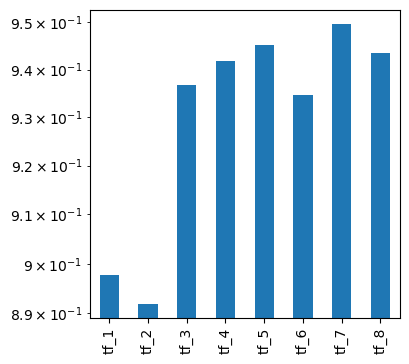

In [42]:
results_df.iloc[10:].roc_auc_score.plot(kind='bar', figsize=(4,4), logy=True)

<Axes: >

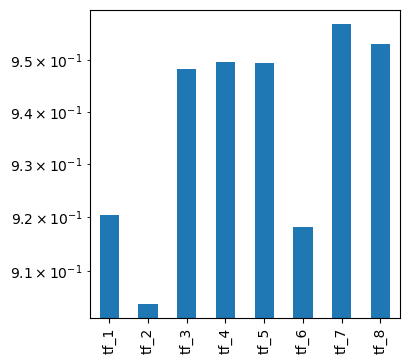

In [43]:
results_df.iloc[10:].precision_recall_auc_score.plot(kind='bar', figsize=(4,4), logy=True)

The best model is tf_7 with a ROC AUC score of and a precision-recall 0.949656 AUC score of 0.957029.

In [44]:
results['tf_7']['model'].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 122)               15006     
                                                                 
 dense_37 (Dense)            (None, 244)               30012     
                                                                 
 dense_38 (Dense)            (None, 100)               24500     
                                                                 
 dense_39 (Dense)            (None, 50)                5050      
                                                                 
 dense_40 (Dense)            (None, 25)                1275      
                                                                 
 dense_41 (Dense)            (None, 10)                260       
                                                                 
 dense_42 (Dense)            (None, 1)                